In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns

from matplotlib.animation import FuncAnimation
import os
import time
from skspatial.objects import Sphere
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Hernquist Density Profile
The density is given by (Galactic Dynamics, James Binney- pg 70):

$$
    \rho(r) = \frac{\rho_0 Rs^4}{r (r + Rs)^3}.
$$

where $Rs$ is the scale radius.

The mass within a given radius r is:

$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 Rs \frac{r^2}{2(1 + \frac{r}{Rs})^2}.
$$
The total mass of the distribution is: 

$$
    M_{tot} = 2 \pi \rho_0 R_s^3 \longrightarrow \rho_0 = \frac{M_{tot}}{2 \pi R_s^3}.
$$

The cumulative distribution function for the radii is:

$$
    P(r) = \frac{M(r)}{M_{tot}} = \frac{r^2}{Rs^2(1 + \frac{r}{Rs})^2} = \frac{r^2}{(Rs + r)^2} 
$$

Inverting this equation, we can find the inverse cumulative distribution function:

$$
    r(P) = \frac{\sqrt{P} Rs}{1 - \sqrt{P}}
$$

The distribution function for $\theta$ and $\phi$ are the ones of a spherically symmetric system:

$$
    P(\phi) = \frac{1}{2 \pi},
$$
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos\theta \right).
$$

In [2]:
N  = 10000  # number of particles 
M  = 1      # total mass of the system
m  = M/N    # mass of the single particle
Rs = 1      # scale radius
G  = 1      # gravitational constant

rho_0 = M / (2 * np.pi * (Rs)**3)  # initial density

# DISTRIBUTION INITIALIZATION

### Density profile
Plotting the expected density profile (just the model)

In [3]:
def Hernquist(r, Rs, rho_0):
    
    return (rho_0 * (Rs**4)) / (r * ((r + Rs)**3))

In [4]:
radii_i  = np.linspace(0.0001, 25 * Rs, N)
rho      = Hernquist(radii_i, Rs, rho_0)

Text(0, 0.5, '$\\rho_H(r)$')

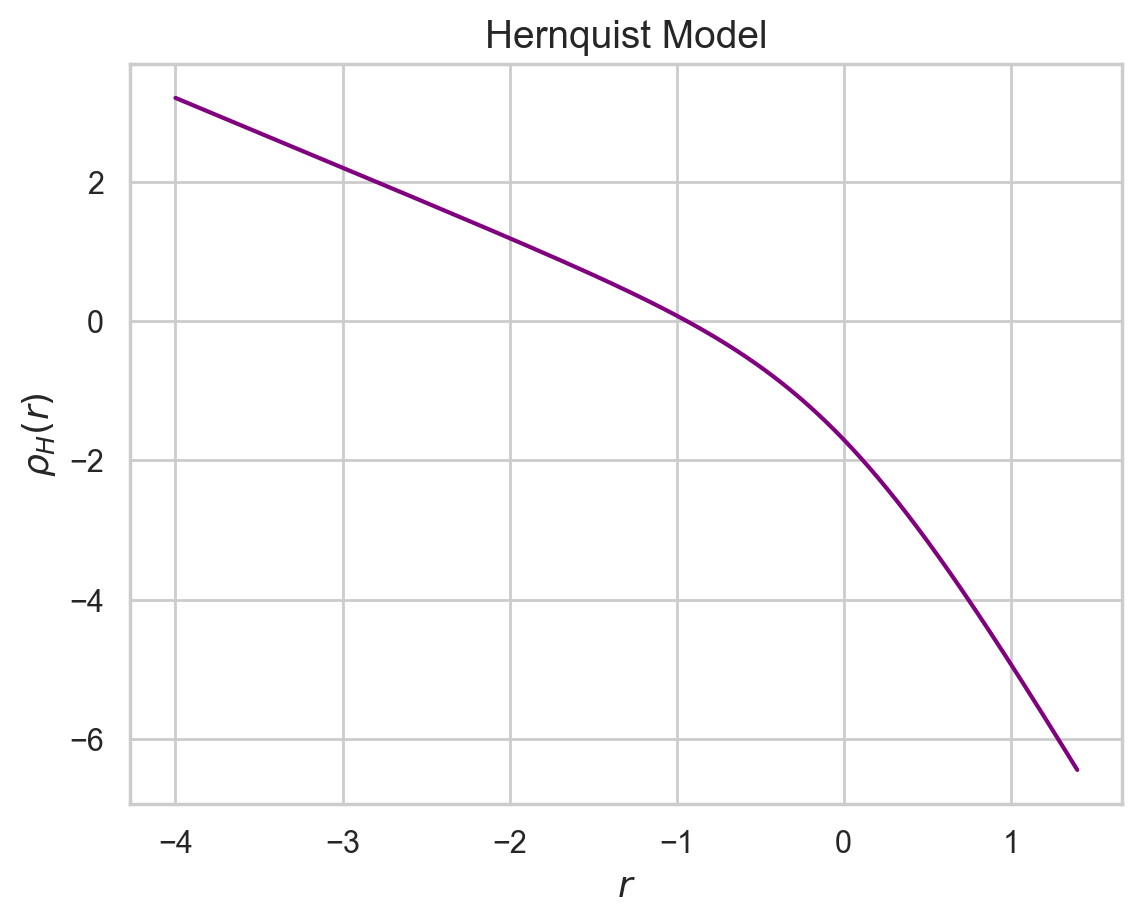

In [5]:
sns.set(style="whitegrid")
plt.plot(np.log10(radii_i), np.log10(rho), color='purple')
plt.title('Hernquist Model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)

### Positions Sampling

In [6]:
def inv_cumulative(P, Rs, N):
    
    return (Rs*np.sqrt(P))/(1 - np.sqrt(P))

In [7]:
# radii
P_r   = np.random.uniform(0, 1, size=N)
radii = inv_cumulative(P_r, Rs, N)

# Theta
cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
theta = np.arccos(1 - 2 * cdf_theta)

# Phi
phi = uniform.rvs(0, 2 * np.pi, size=N)

In [8]:
def calculate_radius(r, percentage):
    # Calculation of the radius containing a certain percentage of particles.
    
    sorted_r = np.sort(r)
    
    index = int(len(sorted_r) * percentage / 100)
    radius = sorted_r[index]
    
    return radius

##################################################################################à

percentage = 75  

radius = calculate_radius(radii, percentage)
print(f"Radius within which {percentage}% of the particles lie: {radius}")
print("Expected radius : ", -1/(1-1/np.sqrt(0.75)))

Radius within which 75% of the particles lie: 6.73799368640985
Expected radius :  6.464101615137748


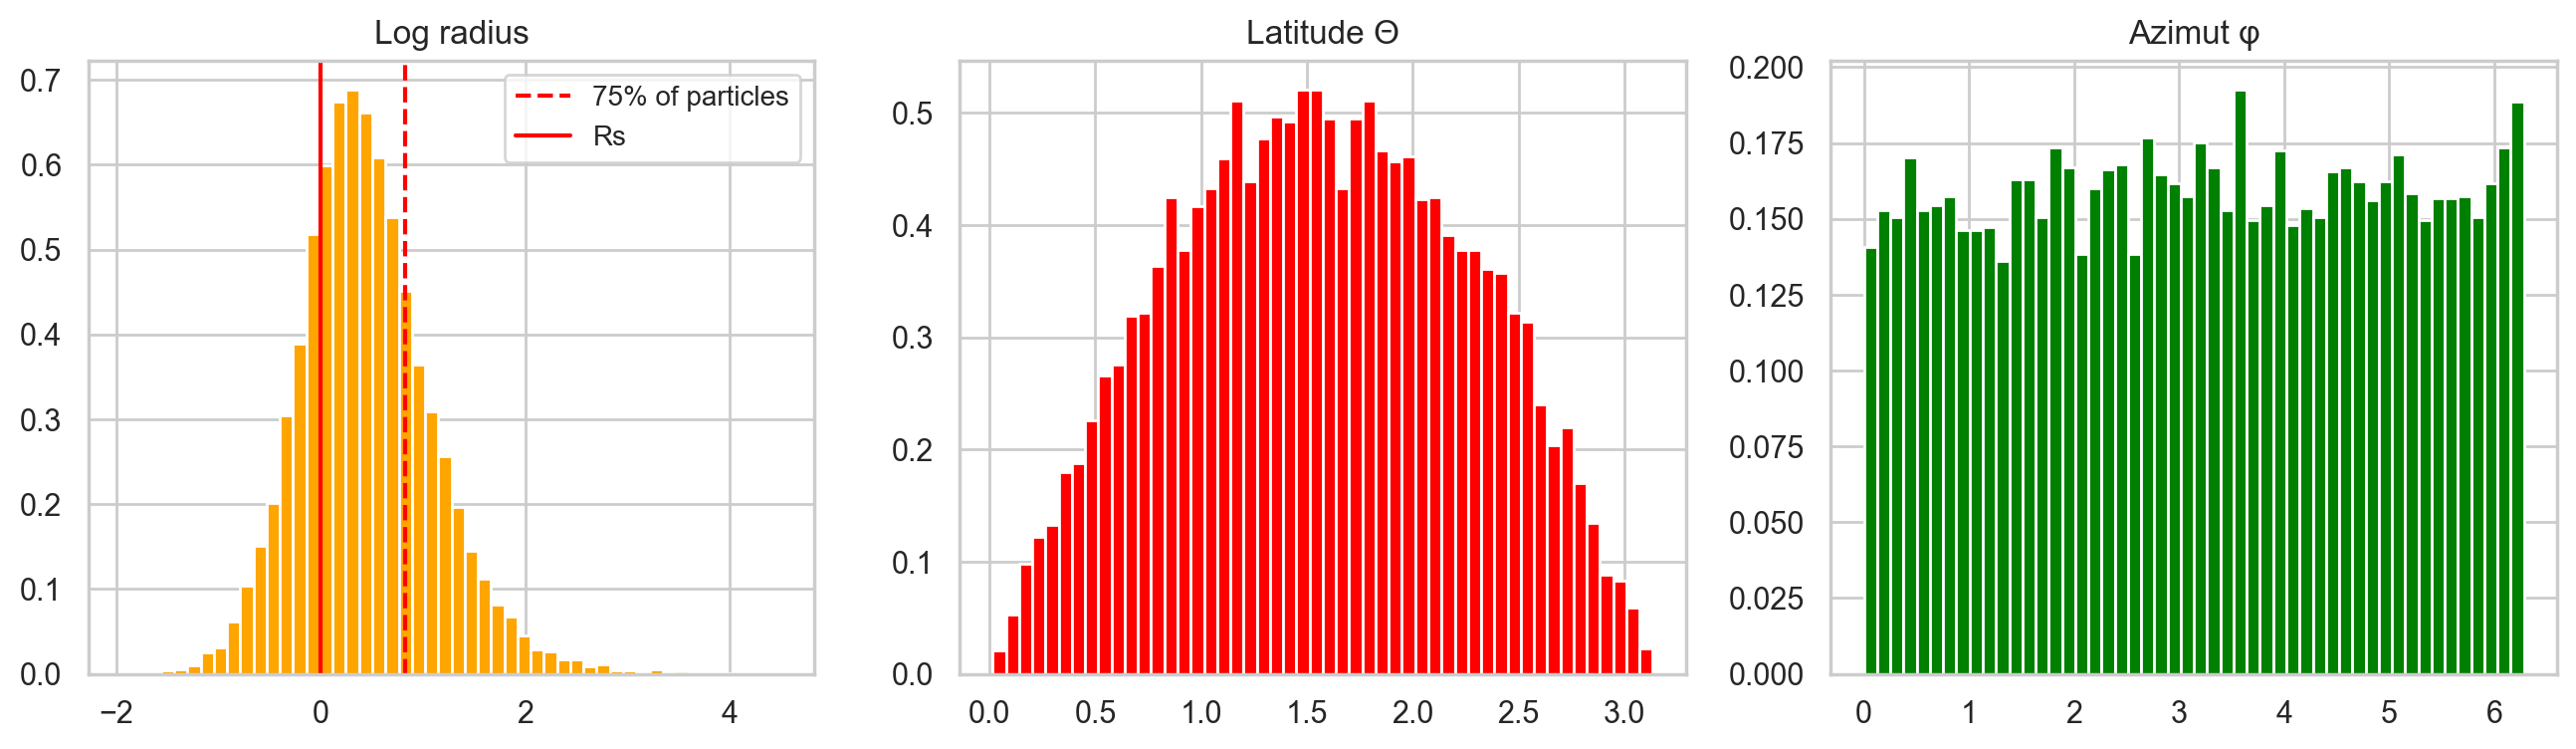

In [9]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].hist(np.log10(radii), bins=50, density=True, color='orange')
axs[0].set_title('Log radius')
axs[0].axvline(x = np.log10(radius) , color='red', linestyle='--',label = '75% of particles')
axs[0].axvline(x = np.log10(Rs) , color='red', label = 'Rs')
axs[0].legend(fontsize=10)

# Plot the histogram of theta on the second column
axs[1].hist(theta, bins=50, density=True, color='red')
axs[1].set_title('Latitude Θ')

# Plot the histogram of phi on the third column
axs[2].hist(phi, bins=50, density=True, color='green')
axs[2].set_title('Azimut φ')

plt.show()

### Distribution Check

In [10]:
# create spherical shells : 29 shells between 0 and 5 times the radius containing 75% of the particles
shell_r = np.linspace(0, radius*5, 30)

# density within each shell
num_part = []
volumes = []

for i in (range(1, len(shell_r))):
    count = sum(1 for r in radii if r >= shell_r[i-1] and r <= shell_r[i])
    volumes.append(4/3 * np.pi * (shell_r[i]**3 - shell_r[i-1]**3))
    num_part.append(count)
    
num_part = np.array(num_part)
volumes  = np.array(volumes)

rho_check = m * num_part / volumes

# remove first element or I get a log(0) (o c'è un log(0))
shell_r = shell_r[1:]

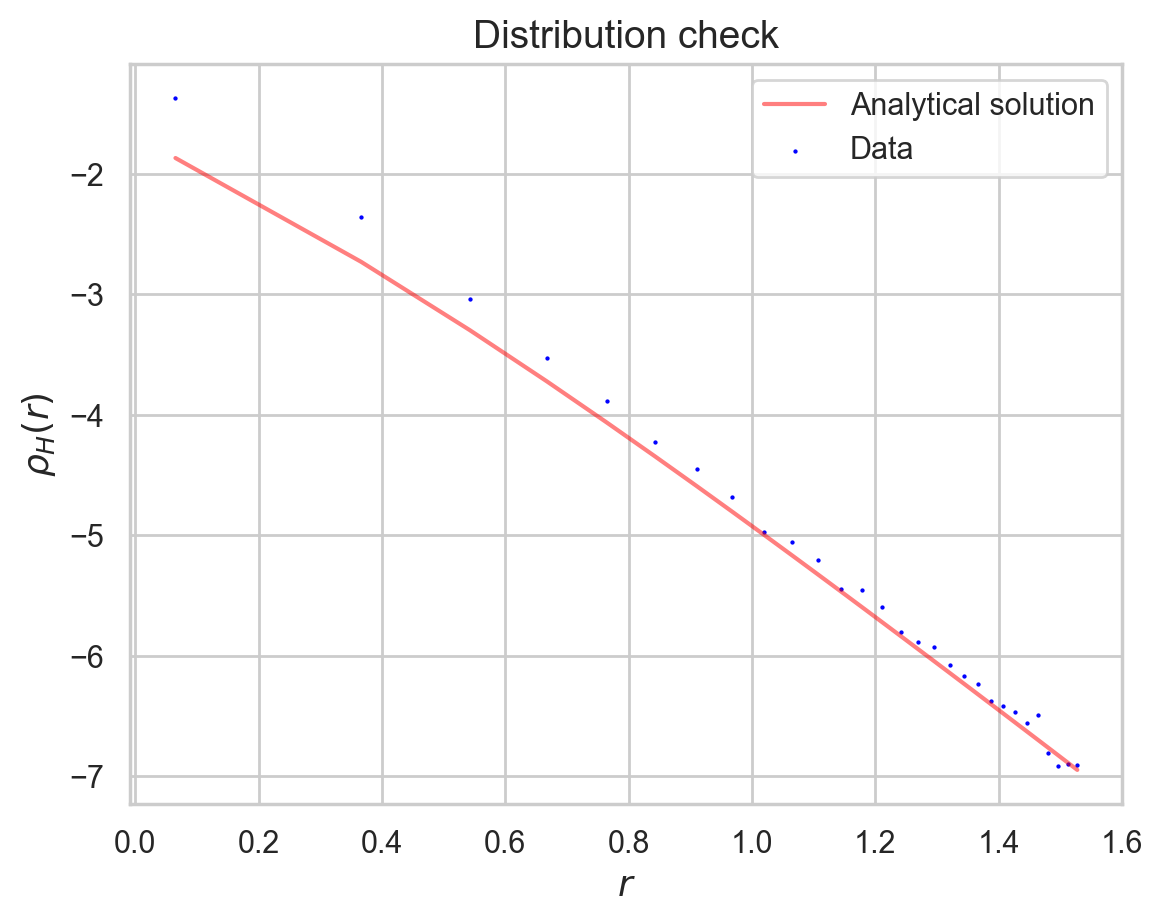

In [11]:
# find the theoretical density from the Hernquist model to compare rho_check
rho_th = Hernquist(shell_r, Rs, rho_0)

sns.set(style="whitegrid")
plt.plot(np.log10(shell_r), np.log10(rho_th), alpha=0.5, color='red', label="Analytical solution")

plt.scatter(np.log10(shell_r), np.log10(rho_check), s=0.3, alpha=1, color='blue', label="Data")

#plt.plot(np.log10(radii_i), np.log10(rho), color='red', alpha=0.5)
plt.title('Distribution check', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)
plt.legend()
#plt.xlim(0.9, 1)



Aumentando il numero di particelle, i dati seguono meglio l'andamento della soluzione analitica

### Cartesian coords

In [12]:
# cartesian coords
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta) 

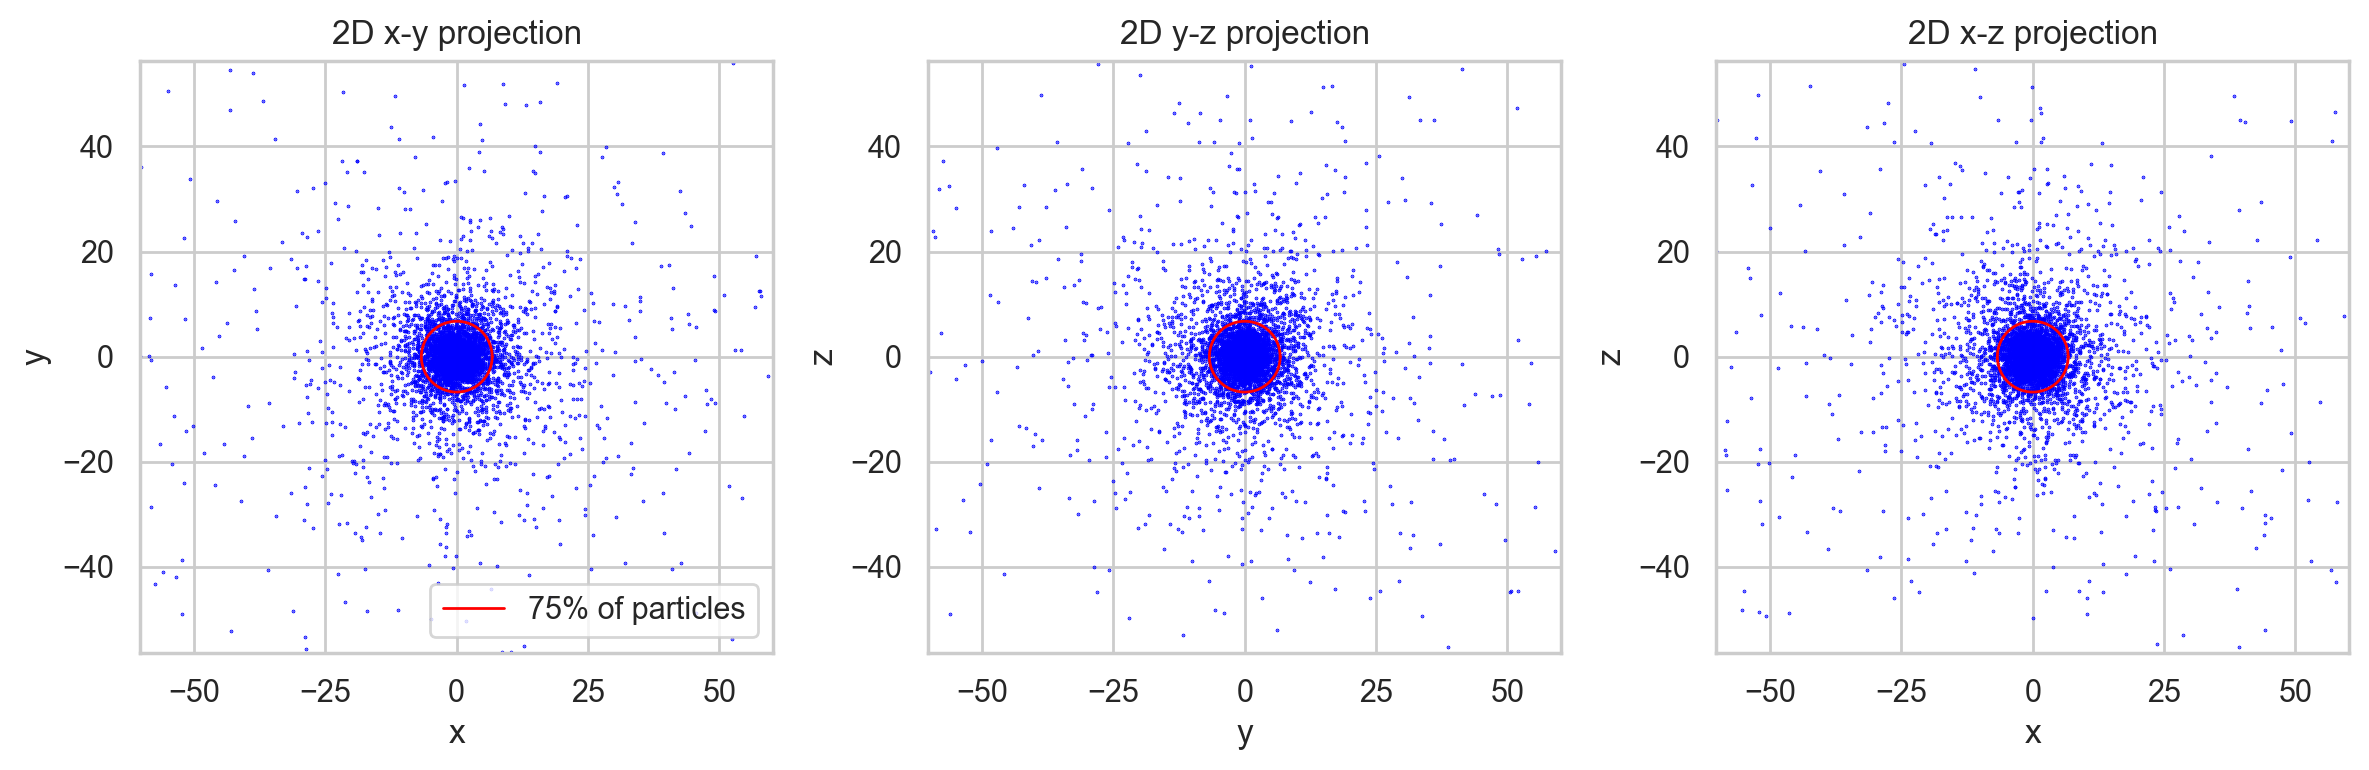

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

theta_lim = np.linspace(0, 2 * np.pi, 150)
a = radius * Rs * np.cos( theta_lim )
c = radius * Rs * np.sin( theta_lim )

axes[0].scatter(x, y, c='blue', s=0.1)
axes[0].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[0].axis('equal')
axes[0].set_xlim(-50, 50)
axes[0].set_ylim(-50, 50)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')
axes[0].legend()

# Projection on y-z plane
axes[1].scatter(y, z, c='blue', s=0.1)
axes[1].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[1].axis('equal')
axes[1].set_xlim(-50, 50)
axes[1].set_ylim(-50, 50)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(x, z, c='blue', s=0.1)
axes[2].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[2].axis('equal')
axes[2].set_xlim(-50, 50)
axes[2].set_ylim(-50, 50)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')


plt.tight_layout()
plt.show()


### Potential

The potential is:

$$
    \Phi(r) =-  4 \pi G \rho_0 Rs^2 \frac{1}{2(1+ \frac{r}{Rs})}
$$

In [14]:
def H_potential(radii, Rs, rho_0):
    return  -4 * np.pi * rho_0 * Rs**2 / (2 * (1 + radii/Rs))

In [15]:
sorted_radii = np.sort(radii)
Psi          = H_potential(sorted_radii, Rs, rho_0)

(-10.0, 100.0)

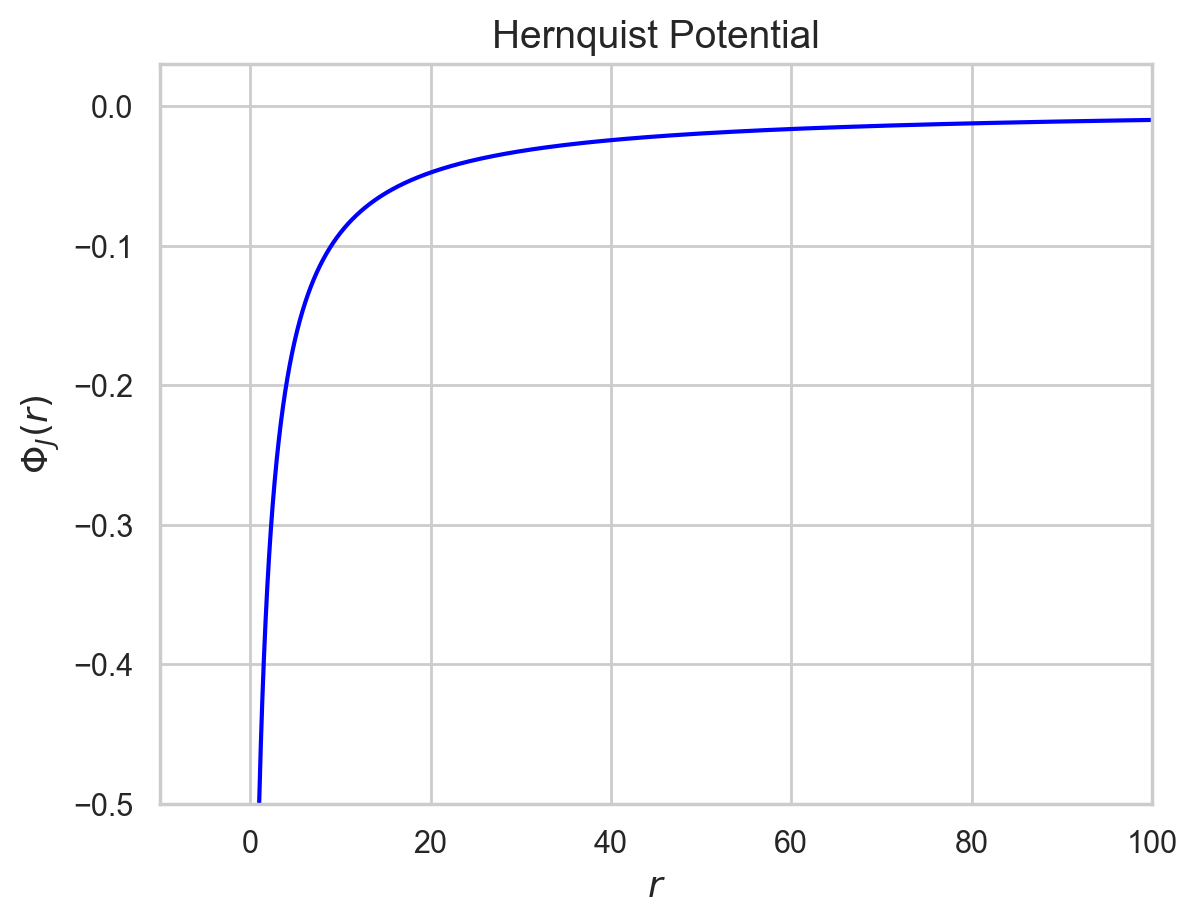

In [16]:
sns.set(style="whitegrid")

plt.plot(sorted_radii, Psi, color='blue')
plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\Phi_J(r)$', fontsize=13)
plt.ylim(-0.5, 0.03)
plt.xlim(-10, 100)

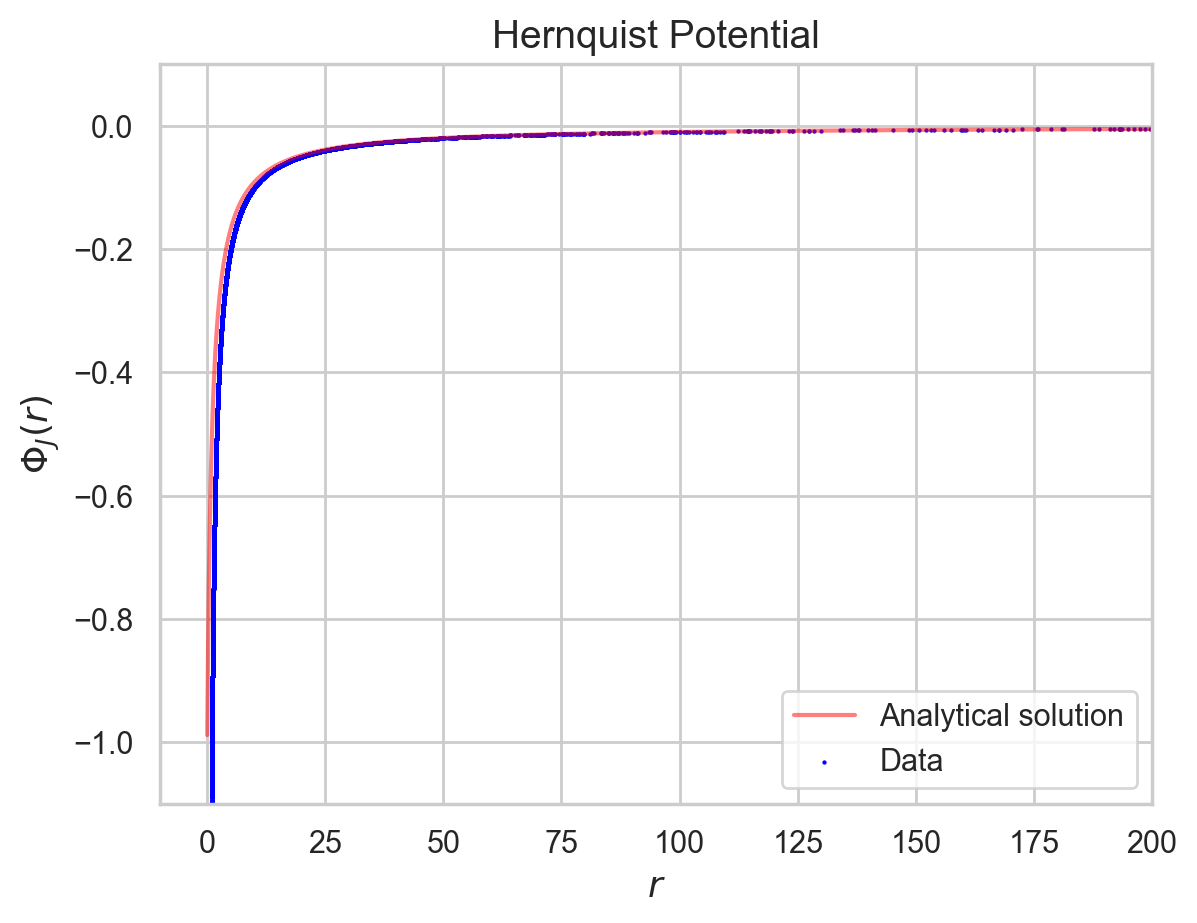

In [17]:
# checking if our particles follow the potential
Psi_check = - M**2 / radii

#########################################################àà

sns.set(style="whitegrid")

plt.plot(sorted_radii, Psi, alpha=0.5, color='red', label="Analytical solution")

plt.scatter(sorted_radii, np.sort(Psi_check), s = 0.3,alpha=1, color='blue', label="Data")


plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\Phi_J(r)$', fontsize=13)
plt.ylim(-1.1, 0.1)
plt.xlim(-10, 200)
plt.legend()

## Distribution Function

Page 302
$$
    f_H(\epsilon)=\frac{1}{\sqrt{2}(2 \pi)^3 (GM R_s)^{\frac{3}{2} }  } \frac{\sqrt{\epsilon}}{(1- \epsilon)^2} \left[ (1-2\epsilon) (8\epsilon ^2 - 8 \epsilon -3) + \frac{3 sin^{-1} \sqrt{\epsilon}}{\sqrt{\epsilon (1 - \epsilon)}}    \right]
$$
where $\epsilon = -\frac{E R_s}{GM}$

In [18]:
def df_H(epsilon, Rs, G, M):

    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * ((G * M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result
    

(-0.1, 1.5)

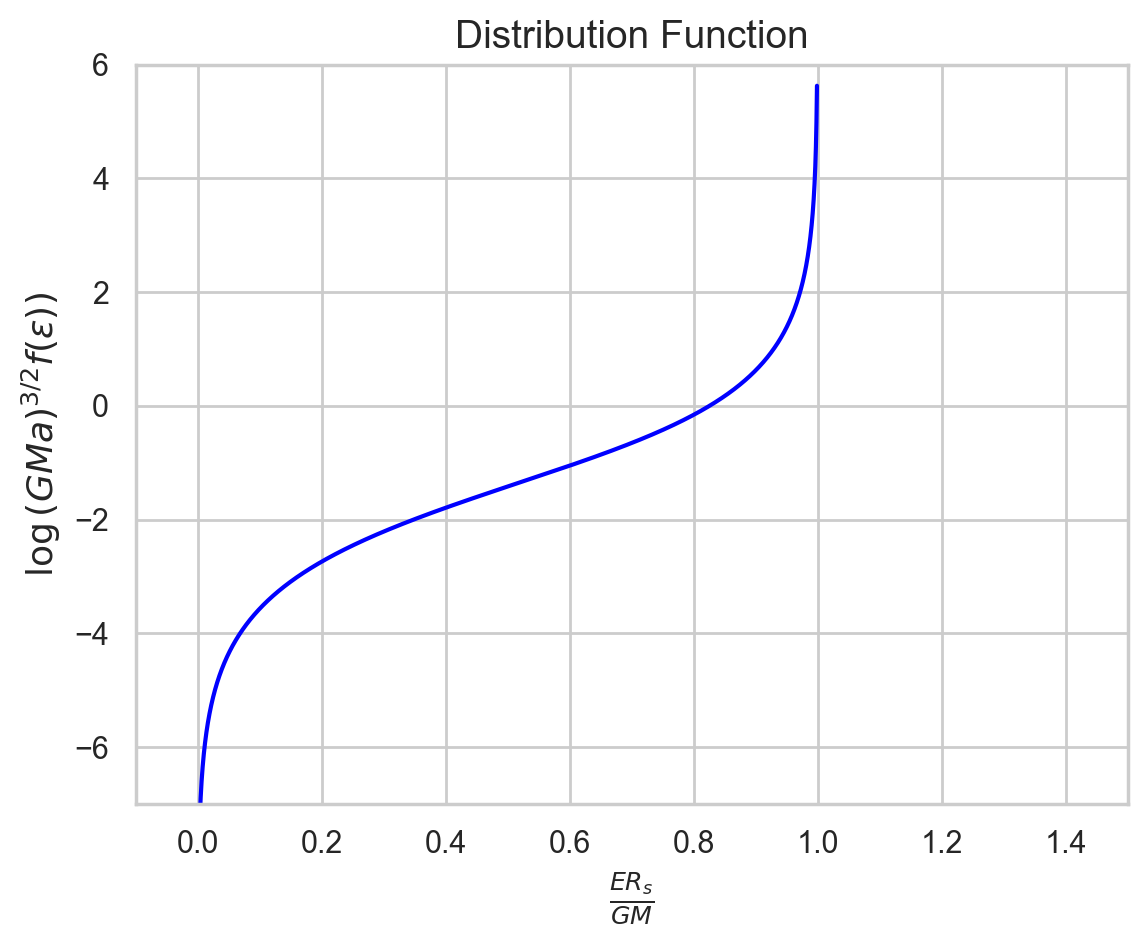

In [19]:
# I plot the distribution function in the same way it's plotted on the book to check if it's correct

asse_x = np.linspace(0.001, 0.999, N) 

E       = asse_x * (G*M/Rs)
epsilon = (E*Rs)/(G*M)
df      = df_H(epsilon, Rs, G, M)

asse_y = np.log10(((G*M*Rs)**(3/2)) * df)

sns.set(style="whitegrid")


plt.plot(E, asse_y, color='blue')
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

plt.ylim(-7,6)
plt.xlim(-0.1,1.5)

## MC rejection method

To sample from the velocities distribution we use the Monte Carlo rejection method to sample the escape velocity $q = \frac{v}{\sqrt{2 \Psi}}$, from which to extract the velocity module:
$F(\epsilon) = \int_0^{\epsilon}f(\epsilon) d^3v = \int_0^{\epsilon}f(\epsilon) 4 \pi v^2 dv = \int_0^1 f(q) q^2 dq $

In [20]:
def df_H_q(Psi,q, Rs, G, M):

    "Uguale a prima ma prendo in input q e lo trasformo in epsilon"
    
    epsilon = -Psi * (1 - q**2)
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * ((G * M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result

####################################################################################

q = np.linspace(0.0001, 0.9999, N) # v/v_escape


x_mc = []
    
for j in range(N):
    Psi_j = Psi[j]
    
    func   = df_H_q(Psi_j, q, Rs, G, M) * q**2

    while True:
        x_rand = uniform.rvs(0, np.max(q))
        y_rand = uniform.rvs(0, np.max(func)) 
                
        if y_rand <= df_H_q(Psi_j, x_rand, Rs, G, M) * x_rand**2:
            
            x_mc.append(x_rand)
            j = j + 1
            break


x_mc = np.array(x_mc )

### Velocities

In [21]:
v_esc = np.sqrt(-2*Psi)
v     = x_mc * v_esc

v_theta_cdf = np.random.uniform(0,1,N)
v_theta     = np.arccos(1 - 2 * v_theta_cdf)

v_phi = np.random.uniform(0, 2 * np.pi, size=N) 

In [22]:
v_x = v * np.sin(v_theta) * np.cos(v_phi)
v_y = v * np.sin(v_theta) * np.sin(v_phi)
v_z = v * np.cos(v_theta)

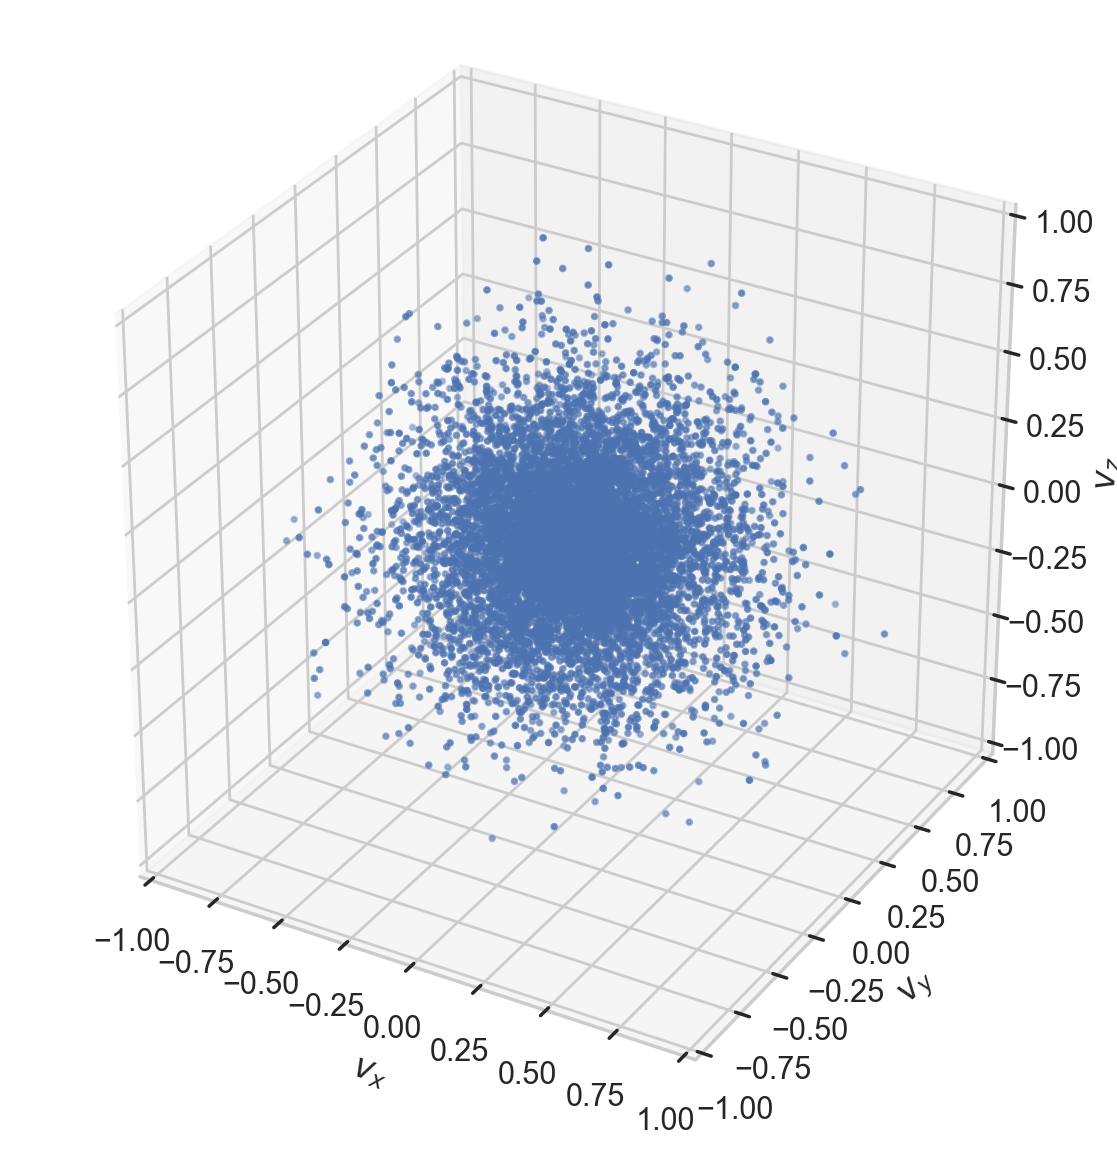

In [23]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.scatter(v_x, v_y, v_z, c = 'b', s=3)
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
plt.show();

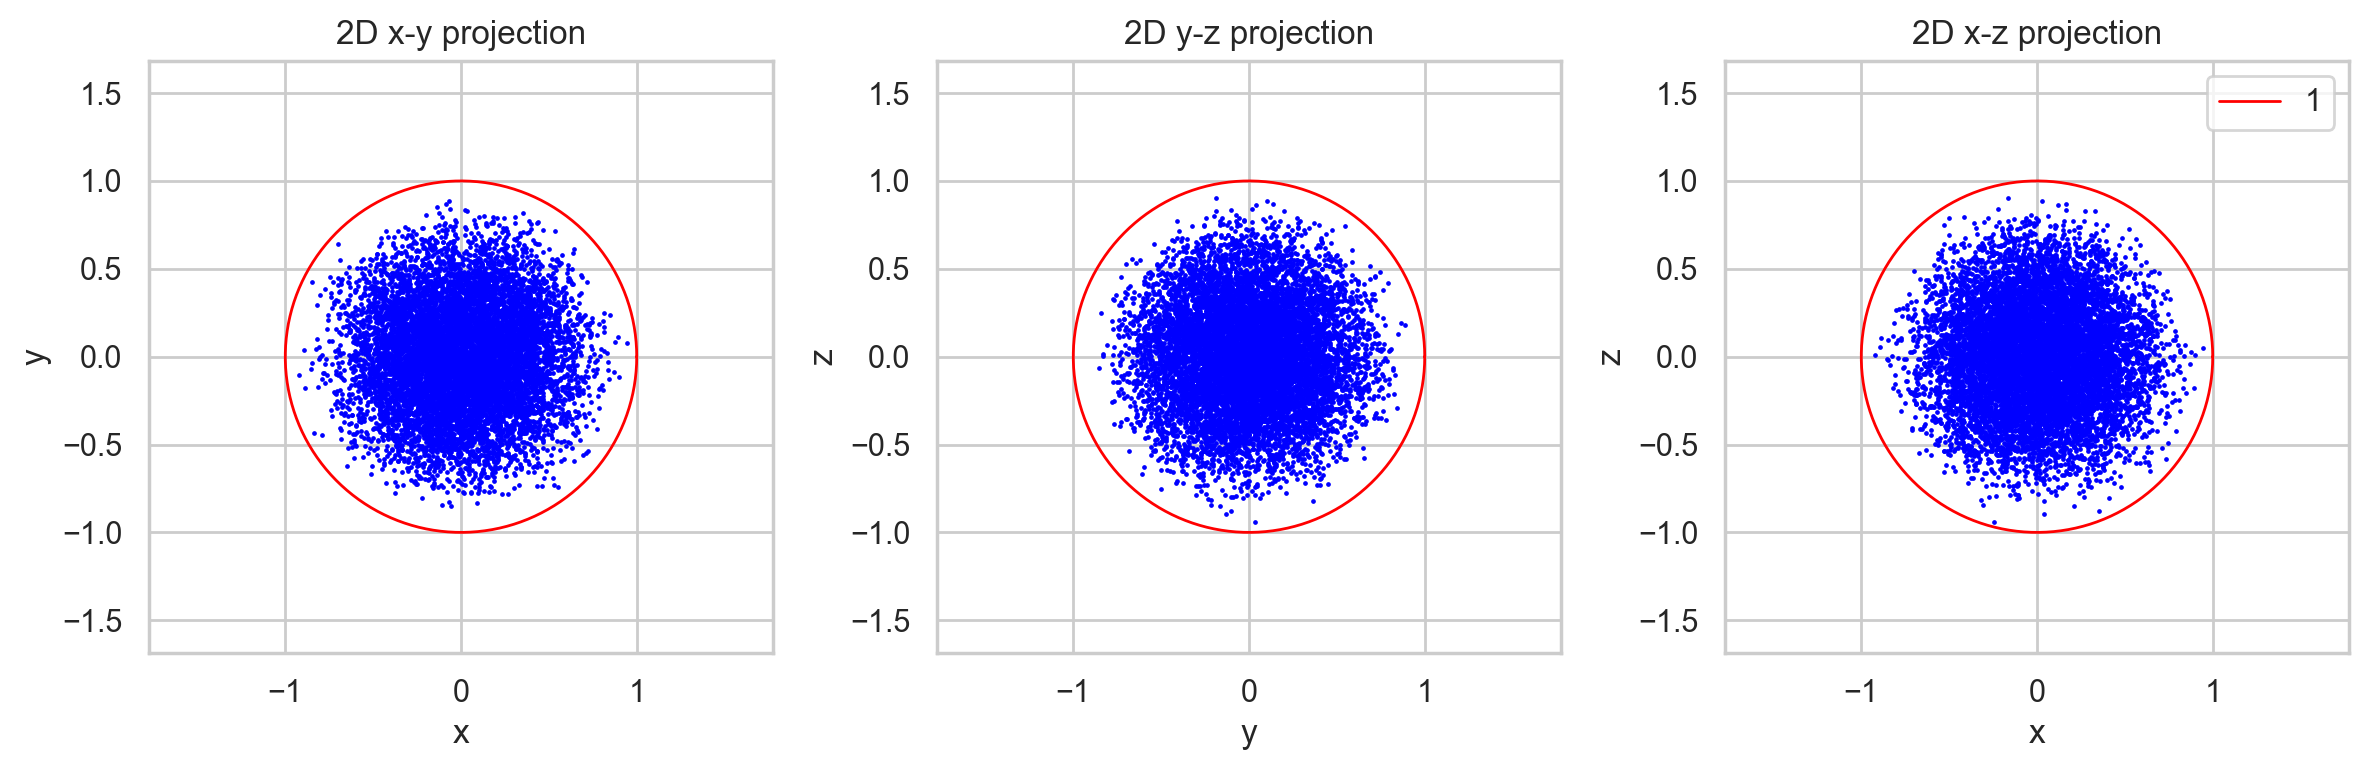

In [24]:
# check - v/v_escape should be contained in an unitary sphere

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

theta_lim = np.linspace(0, 2 * np.pi, 150)
v_a = 1* np.cos( theta_lim )
v_c = 1* np.sin( theta_lim )

################################################################################################
axes[0].scatter(v_x/v_esc, v_y/v_esc, c='blue', s=0.5)
axes[0].plot(v_a, v_c, c='red', linewidth=1, label=r'75% of particles')
axes[0].axis('equal')
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(v_y/v_esc, v_z/v_esc, c='blue', s=0.5)
axes[1].plot(v_a, v_c, c='red', linewidth=1, label=r'75% of particles')
axes[1].axis('equal')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(v_x/v_esc, v_z/v_esc, c='blue', s=0.5)
axes[2].plot(v_a, v_c, c='red', linewidth=1, label=r'1')
axes[2].axis('equal')
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()


## Initial conditions

In [25]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_H.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [26]:
T_dyn = (3*np.pi/(16*G*rho_0))**(1/2)
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(10 * T_dyn)
print("Simulation time: ", T_sim)

dt = 1/10
theta = 0.2
t_out = dt

Dynamical Time:  1.9238247452427961
Epsilon:  0.0075
Simulation time:  19.0


In [27]:
print('./treecode in=in_H.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=out_H.txt >logout_H.txt')


./treecode in=in_H.txt  dtime=0.1 theta=0.2 tstop=19.0 dtout=0.1 out=out_H.txt >logout_H.txt


# ANALYSIS

In [28]:
# reading the data 

lines = pd.read_csv('out_H.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

# radii
r_s = np.sqrt(x_s**2 + y_s**2 + z_s**2)

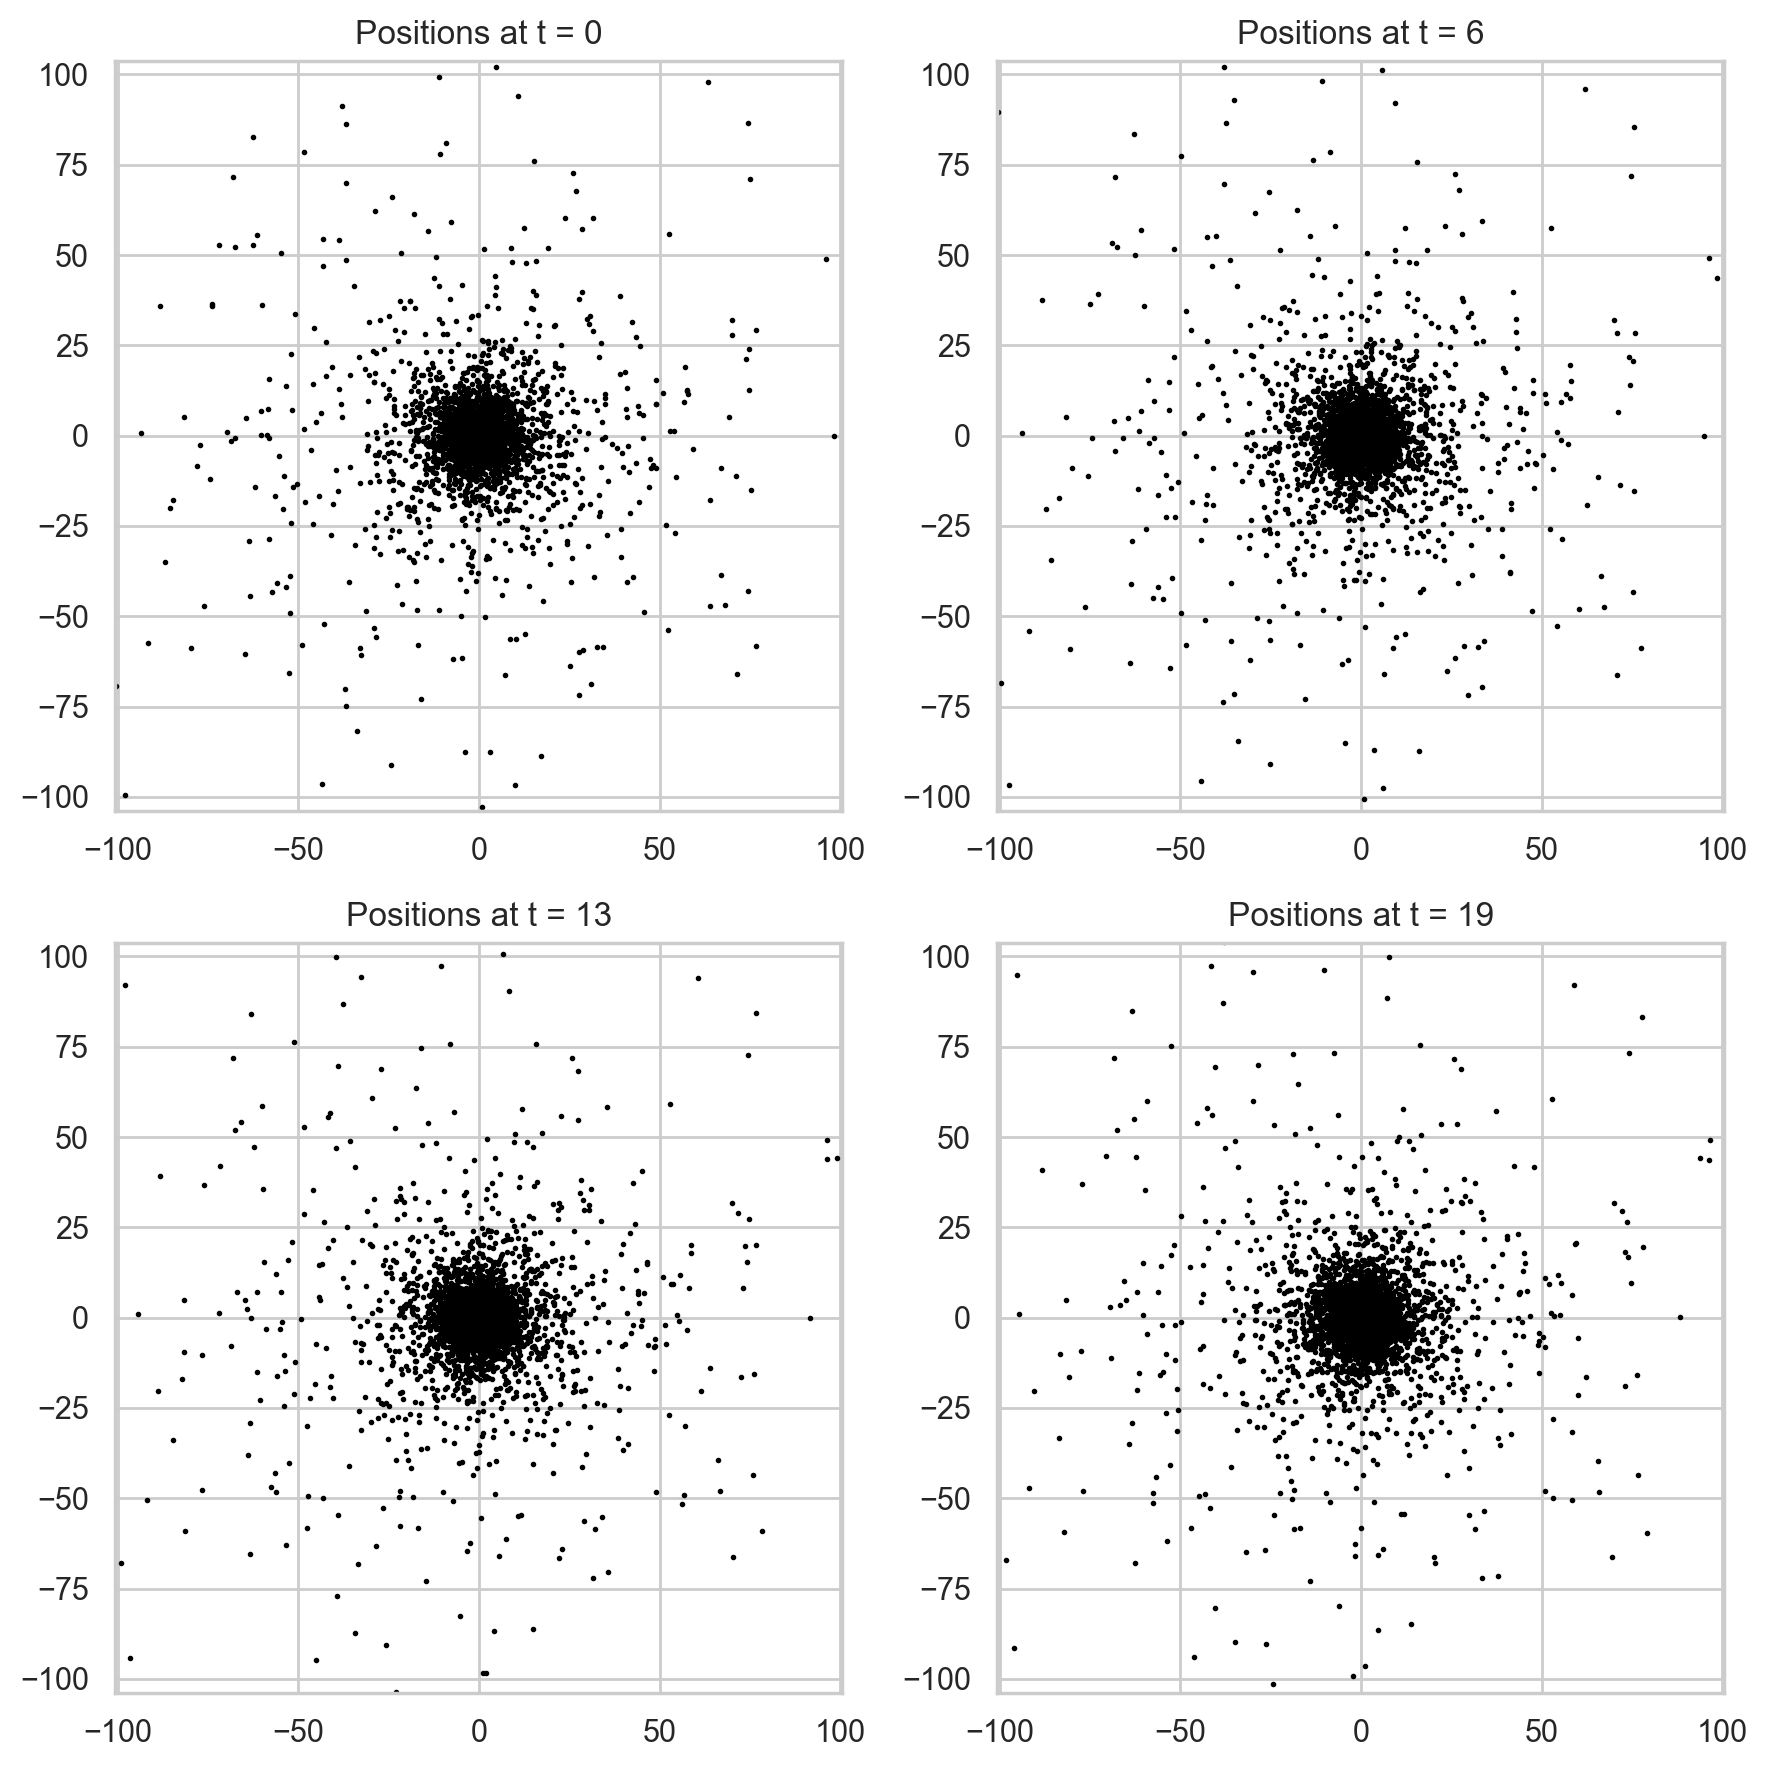

In [29]:
# showing how the distribution evolves at 4 different times just to have an idea of how it behaves before creating the animation

t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1


sns.set(style="whitegrid")
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
#ax[0][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][0].axis('equal')
#ax[0][0].legend(fontsize='large')
ax[0][0].set_xlim(-100, 100)
ax[0][0].set_ylim(-100, 100)


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)#, label='Particles at t1')

ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
#ax[0][1].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][1].axis('equal')
#ax[0][1].legend(fontsize='large')
ax[0][1].set_xlim(-100, 100)
ax[0][1].set_ylim(-100, 100)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)#, label='Particles at t2')

ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
#ax[1][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[1][0].axis('equal')
#ax[1][0].legend(fontsize='large')
ax[1][0].set_xlim(-100, 100)
ax[1][0].set_ylim(-100, 100)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)#, label='Particles at t=T_sim')
#ax[1][1].plot(a, c, c='red', linewidth=1, label=r'5 Rs')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
#ax[1][1].legend()
ax[1][1].set_xlim(-100, 100)
ax[1][1].set_ylim(-100, 100)

plt.show()

  0%|          | 0/191 [00:00<?, ?it/s]

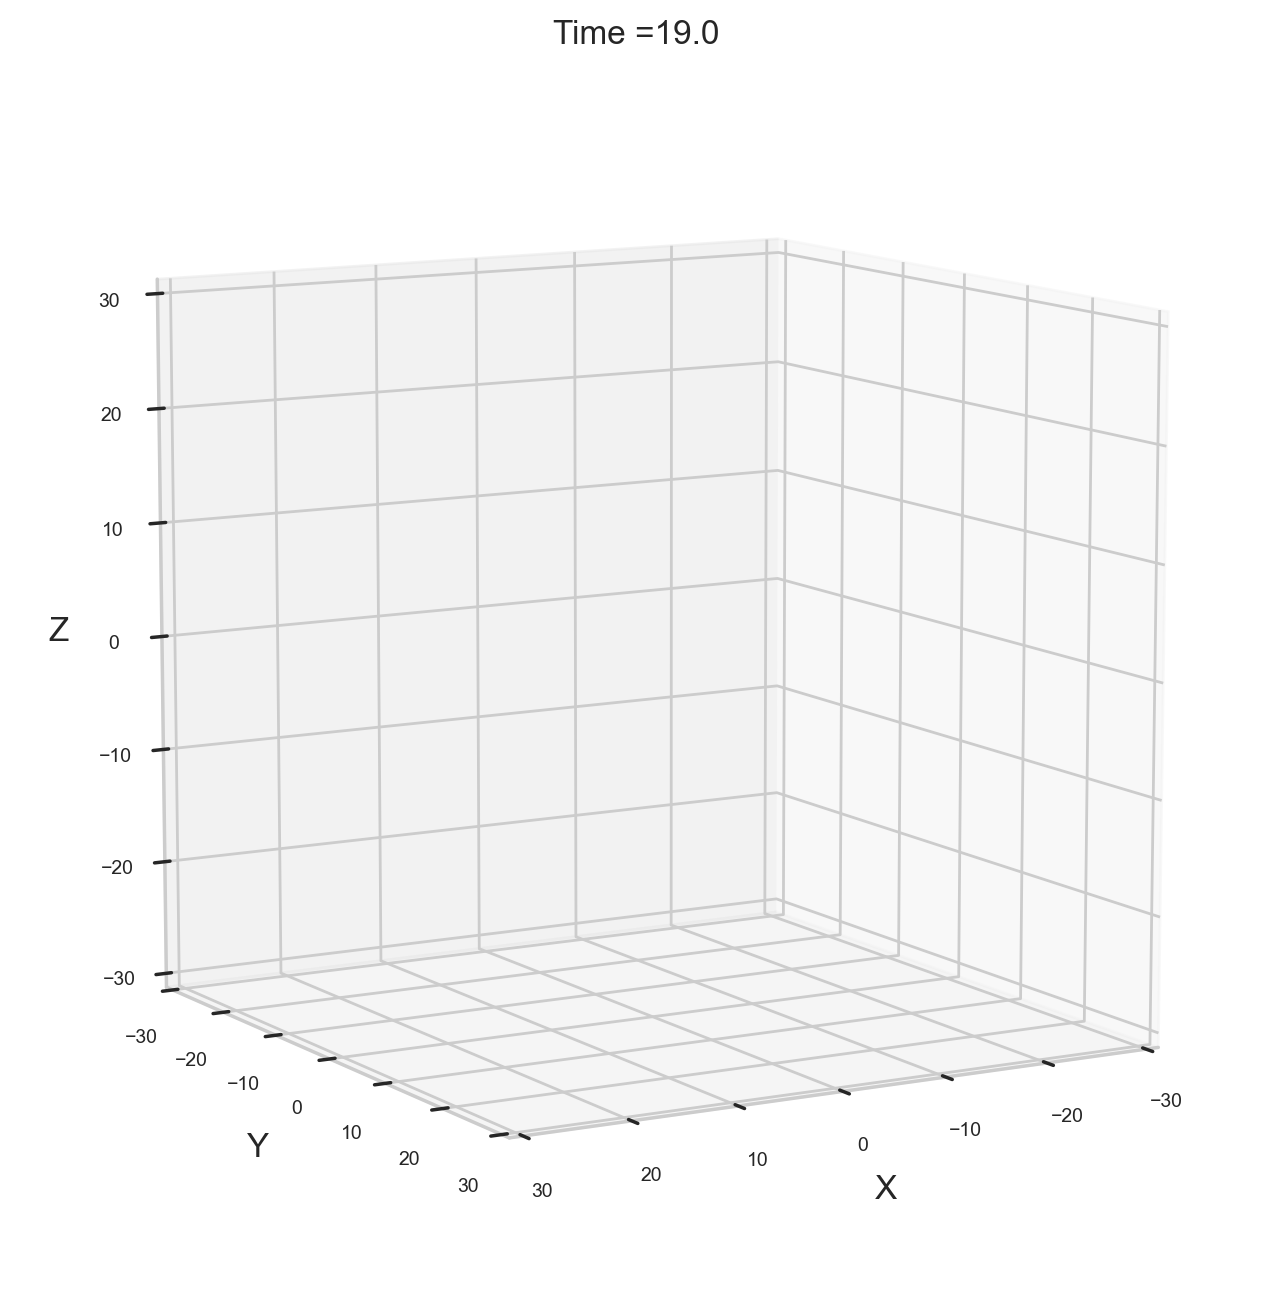

In [30]:
# ANIMATION


from tqdm.notebook import tqdm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.view_init(elev=10, azim=60)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
scatters, = ax.plot([], [], [], 'o', markersize='0.8', alpha=0.3)


def init():
    scatters.set_data([], [])
    scatters.set_3d_properties([])
    return scatters,

def animate_time(i): 
    scatters.set_data(x_s[:,i], y_s[:,i])
    scatters.set_3d_properties(z_s[:,i])
    ax.set_title('Time =' + str(np.round((np.array(t_s))[i])))
        
    return scatters,


num_frames = int(len(t_s))
animazione = FuncAnimation(fig, animate_time, frames=tqdm(range(num_frames)), interval=0.0001, init_func=init) #frames = num_frames interval =100

#theta_ = np.linspace(0,2*np.pi,1000)

writergif = animation.PillowWriter(fps=60)
animazione.save(f'Hernquist.gif', writer = writergif)
#plt.show()

plt.rcParams['animation.html'] = 'html5'


### Lagrangian radius

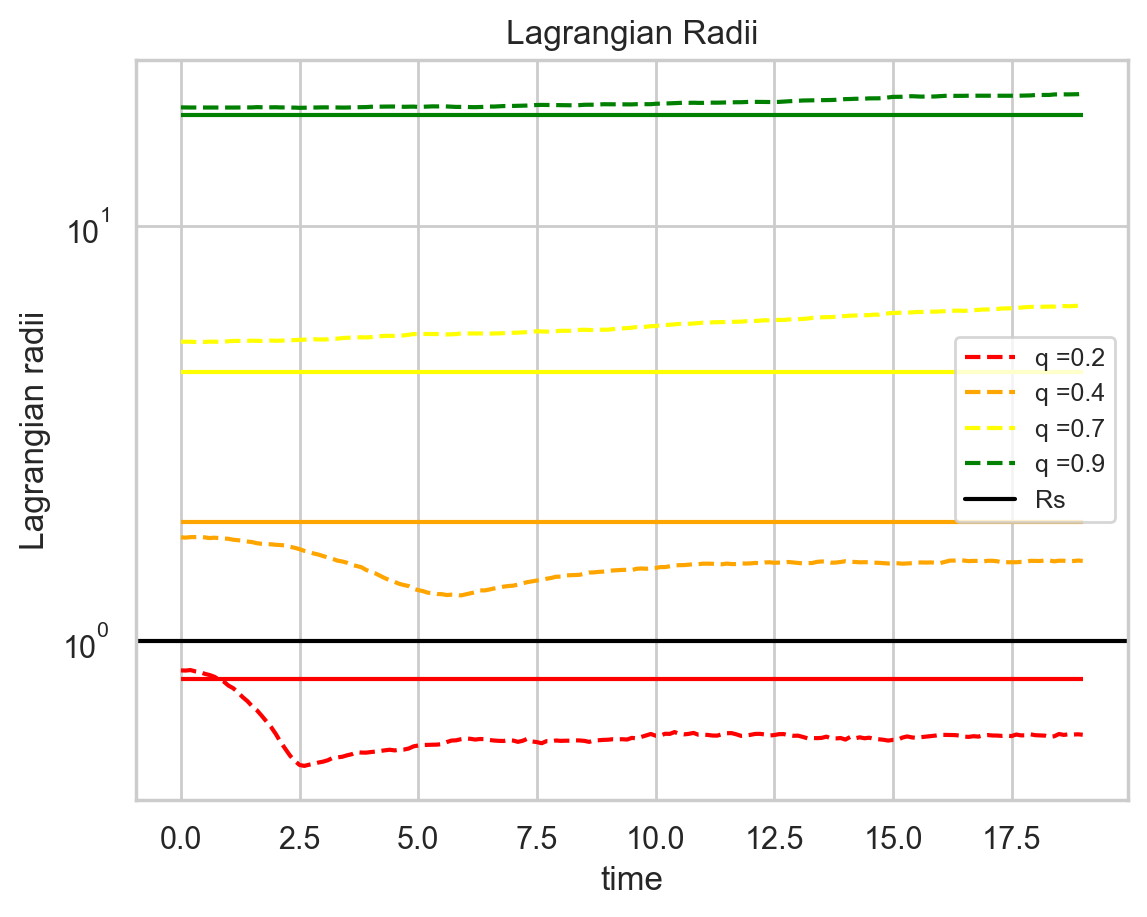

In [31]:
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    for i in range(len(radius_array[0])):
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)


# theoretical lagrangian radii
#def Lagrangian_th(Rs, quantile): 
#    
#    #r = (quantile * Rs**3)**(1/3)
#    r = Rs / (1-np.sqrt(quantile))
    
#    return inv_cumulative(r, Rs, N)

##############################################################################
quantiles = np.linspace(0.2, 0.9, 4)
colors = ['red', 'orange', 'yellow' , 'green', 'blue', 'pink', 'purple', 'brown', 'cyan']


# real Lagrangian Radii
L1 = []
L2 = []
L3 = []
L4 = []

L1 = Lagrangian_Radius(r_s, round(quantiles[0],1))
L2 = Lagrangian_Radius(r_s, round(quantiles[1],1))
L3 = Lagrangian_Radius(r_s, round(quantiles[2],1))
L4 = Lagrangian_Radius(r_s, round(quantiles[3],1))

plt.plot(t_s, L1, linestyle= '--',label='q ='+str(round(quantiles[0],1)),  c=colors[0])   
plt.plot(t_s, L2, linestyle= '--',label='q ='+str(round(quantiles[1],1)),  c=colors[1])   
plt.plot(t_s, L3, linestyle= '--',label='q ='+str(round(quantiles[2],1)),  c=colors[2])   
plt.plot(t_s, L4, linestyle= '--',label='q ='+str(round(quantiles[3],1)),  c=colors[3]) 


# Theoretical Lagrangian Radii
#for i in range(len(quantiles)):
#    plt.hlines(Lagrangian_th(Rs, quantiles[i]), 0, np.max(t_s), colors=colors[i])

# Theoretical Lagrangian Radii
for i in range(len(quantiles)):
    plt.hlines(inv_cumulative(quantiles[i], Rs, N), 0, np.max(t_s), colors=colors[i])

plt.axhline(Rs, label='Rs', color='black')
plt.ylabel('Lagrangian radii')
plt.xlabel('time')
plt.title('Lagrangian Radii')
plt.yscale('log')
#plt.margins(.05)
#plt.ylim(0.1,15)
plt.legend(fontsize=9)

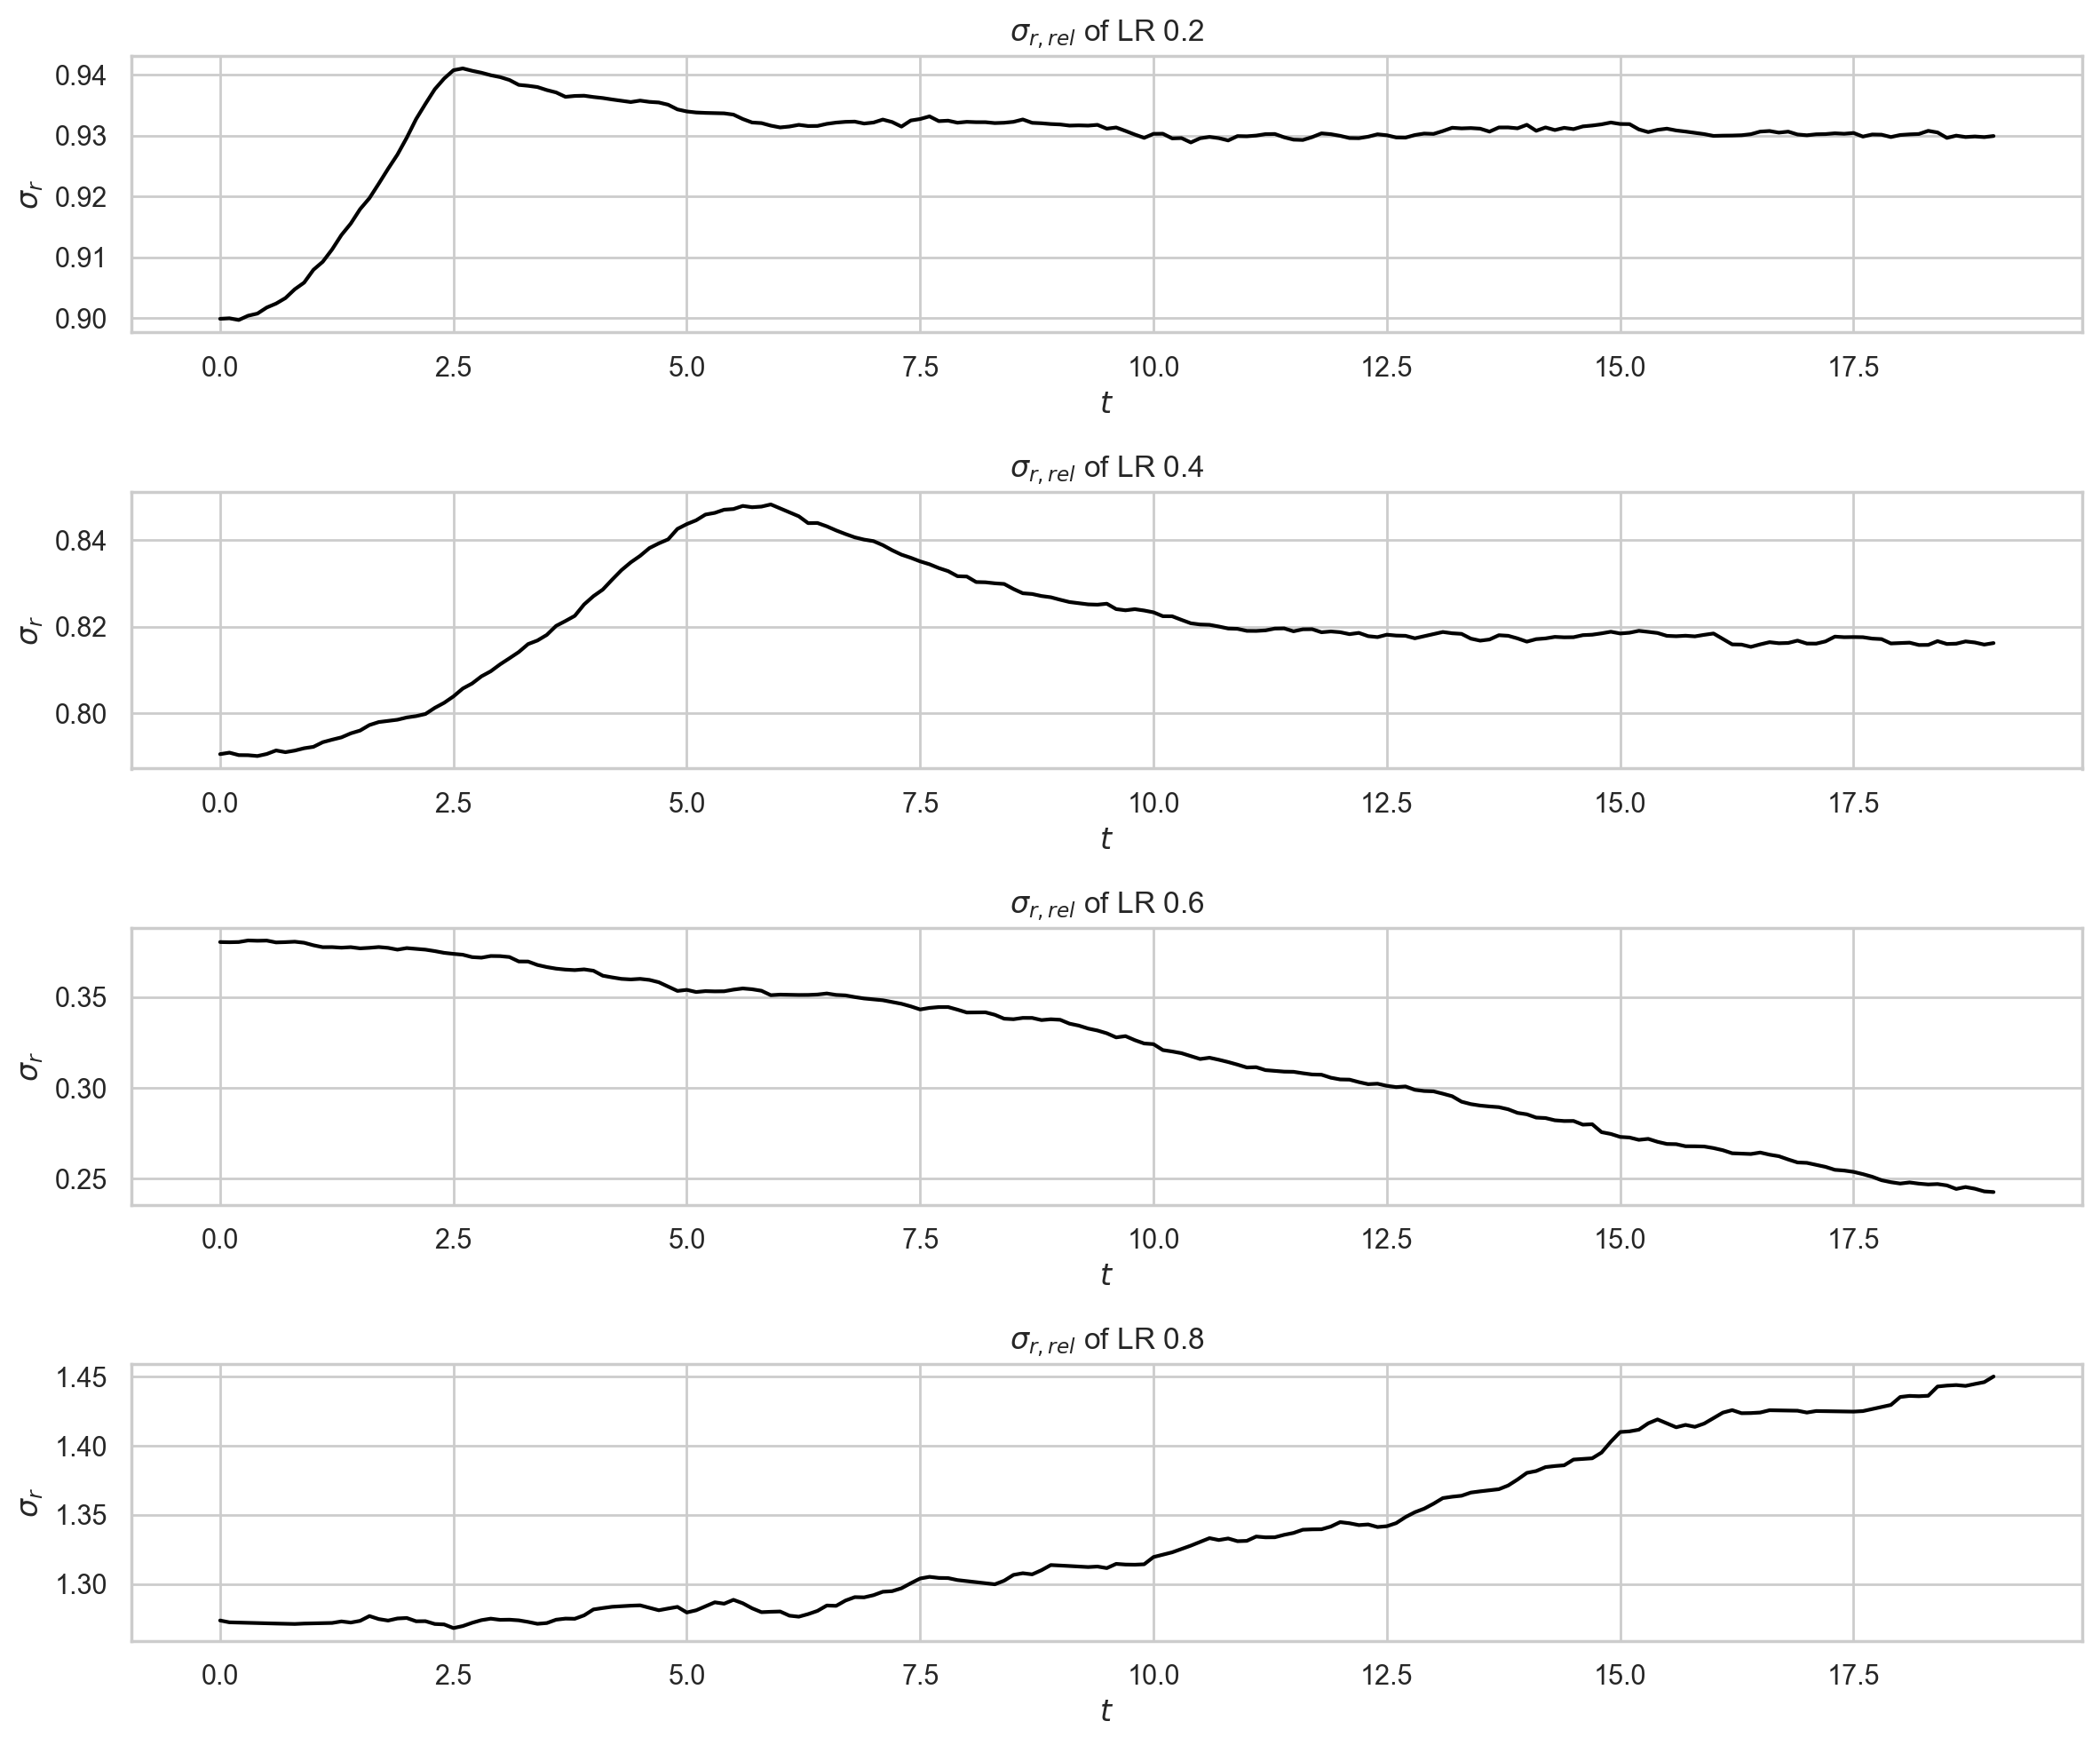

In [32]:
# plot the relative error with respect to the ideal Lagrangian radius:

sigma_r = {}

for lag_radius in [L1, L2, L3, L4]:
    sigma_r[f"{lag_radius}"] = [np.abs(inv_cumulative(0.8, Rs, N) - lag_radius[i])/inv_cumulative(0.8, Rs, N) for i in range(0, len(t_s))]



fig, ax = plt.subplots(4, figsize=(12, 10))
for i, lag_radius, index in zip(range(0, 4), [L1, L2, L3, L4], [0.2, 0.4, 0.6, 0.8]): 

    ax[i].plot(t_s, sigma_r[f"{lag_radius}"], c='black')
    ax[i].set_ylabel("$\sigma_{r}$")
    ax[i].set_xlabel("$t$")
    ax[i].set_title(f"$\sigma_{{r, rel}}$ of LR {index}")
    ax[i].margins(0.05, 0.05)

plt.tight_layout()
plt.show()


### Distribution check

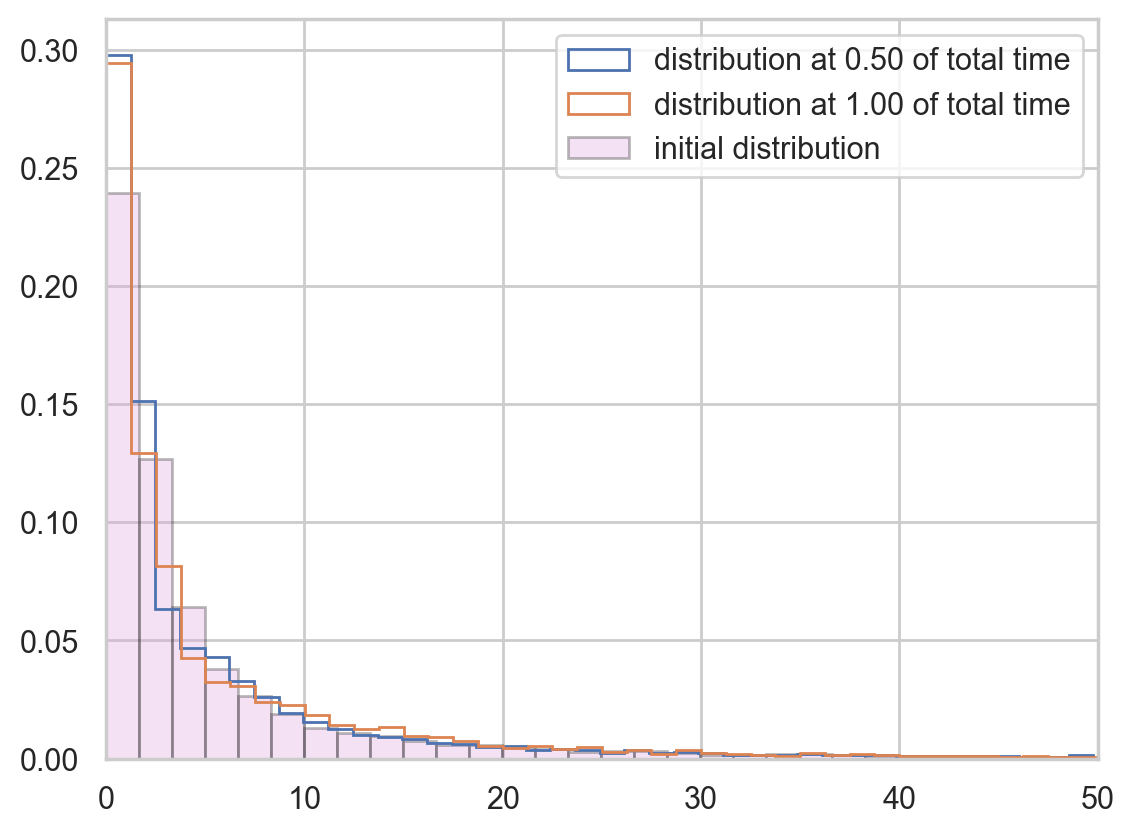

In [33]:
def distribution(frac):
    t = int(len(t_s)*frac)
    r_t = r_s[:,t-1]
    plt.hist(r_t[r_t<50], bins=40, density=True, histtype='step', label='distribution at %.2f of total time' %frac)


f=[0.5,1]
for frac in f:
    distribution(frac)
    
plt.hist(radii[radii<50], bins=30, density=True, alpha=0.3, color='plum', ec='k', histtype='bar', label='initial distribution');
plt.xlim(0,50)
plt.legend();

# CoM

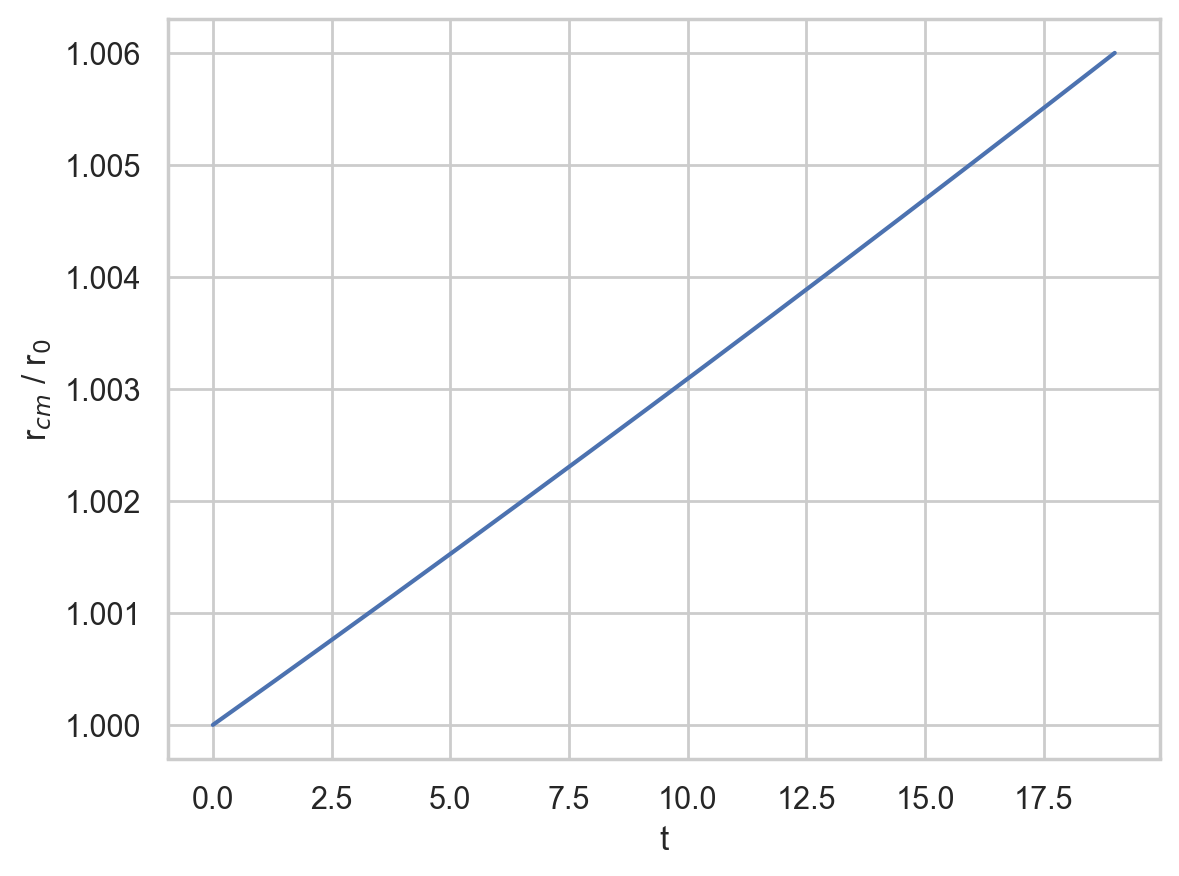

In [34]:
mu = m / M

x_cm = mu * np.sum(x_s, axis = 0)
y_cm = mu * np.sum(y_s, axis = 0)
z_cm = mu * np.sum(z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

### Energy conservation

In [36]:
# reading the output file
energy = pd.read_csv('logout_H.txt', header=None).to_numpy()

# seleziono le righe dalle quali prendere i dati: sono quelle successive alle righe contenenti la aprola "time"
good_rows = [i+1 for i, row in enumerate(energy) if '        time' in row[0]]

# da queste righe prendo i dati
good_data = [energy[index] for index in good_rows] 
good_data = np.array(good_data)

In [37]:
(good_data)

array([['       0.000 0.07781 0.08303 0.16084 0.51621 0.00472 0.96355   0.013'],
       ['       0.100 0.07781 0.08311 0.16091 0.51647 0.00472 0.96355   0.034'],
       ['       0.200 0.07781 0.08338 0.16118 0.51728 0.00472 0.96355   0.049'],
       ['       0.300 0.07780 0.08385 0.16165 0.51871 0.00472 0.96355   0.062'],
       ['       0.400 0.07780 0.08455 0.16235 0.52081 0.00472 0.96355   0.075'],
       ['       0.500 0.07780 0.08550 0.16331 0.52357 0.00472 0.96355   0.088'],
       ['       0.600 0.07779 0.08670 0.16449 0.52707 0.00472 0.96355   0.104'],
       ['       0.700 0.07780 0.08814 0.16595 0.53116 0.00472 0.96355   0.119'],
       ['       0.800 0.07781 0.08985 0.16766 0.53591 0.00472 0.96355   0.135'],
       ['       0.900 0.07783 0.09182 0.16964 0.54122 0.00472 0.96355   0.149'],
       ['       1.000 0.07782 0.09403 0.17185 0.54715 0.00472 0.96355   0.163'],
       ['       1.100 0.07786 0.09643 0.17429 0.55329 0.00472 0.96355   0.176'],
       ['       1.200 0.0778

In [38]:
time_energy = []
T   = []
U   = []

for i in range (0, len(good_data)):
    time_energy.append(float(good_data[i][0][6:12]))
    T.append(float(good_data[i][0][21:28]))
    U.append(float(good_data[i][0][30:36]))
                    
time_energy = np.array(time_energy)
T = np.array(T)
U = -np.array(U)
E_tot = T + U

mean_E   = np.average(E_tot)
E_stdev  = np.std(E_tot)

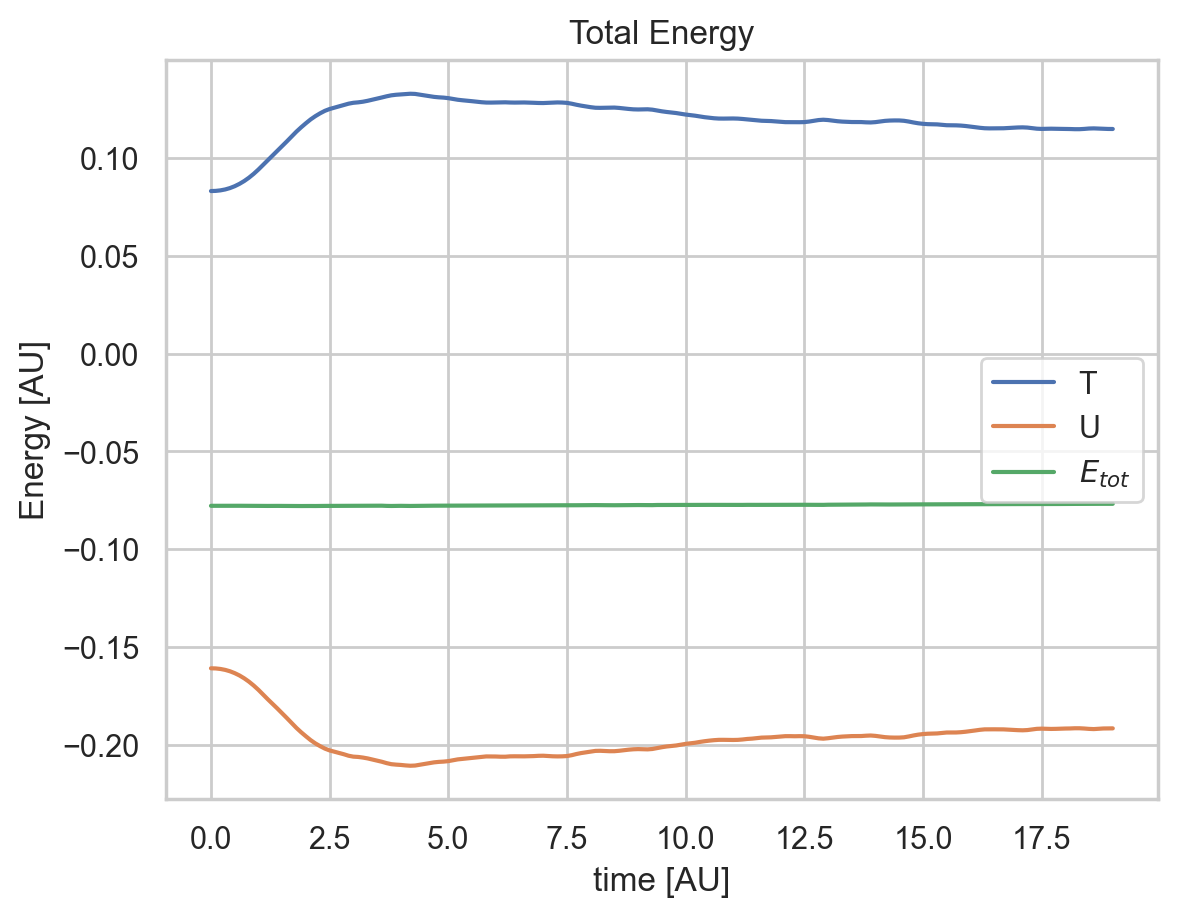

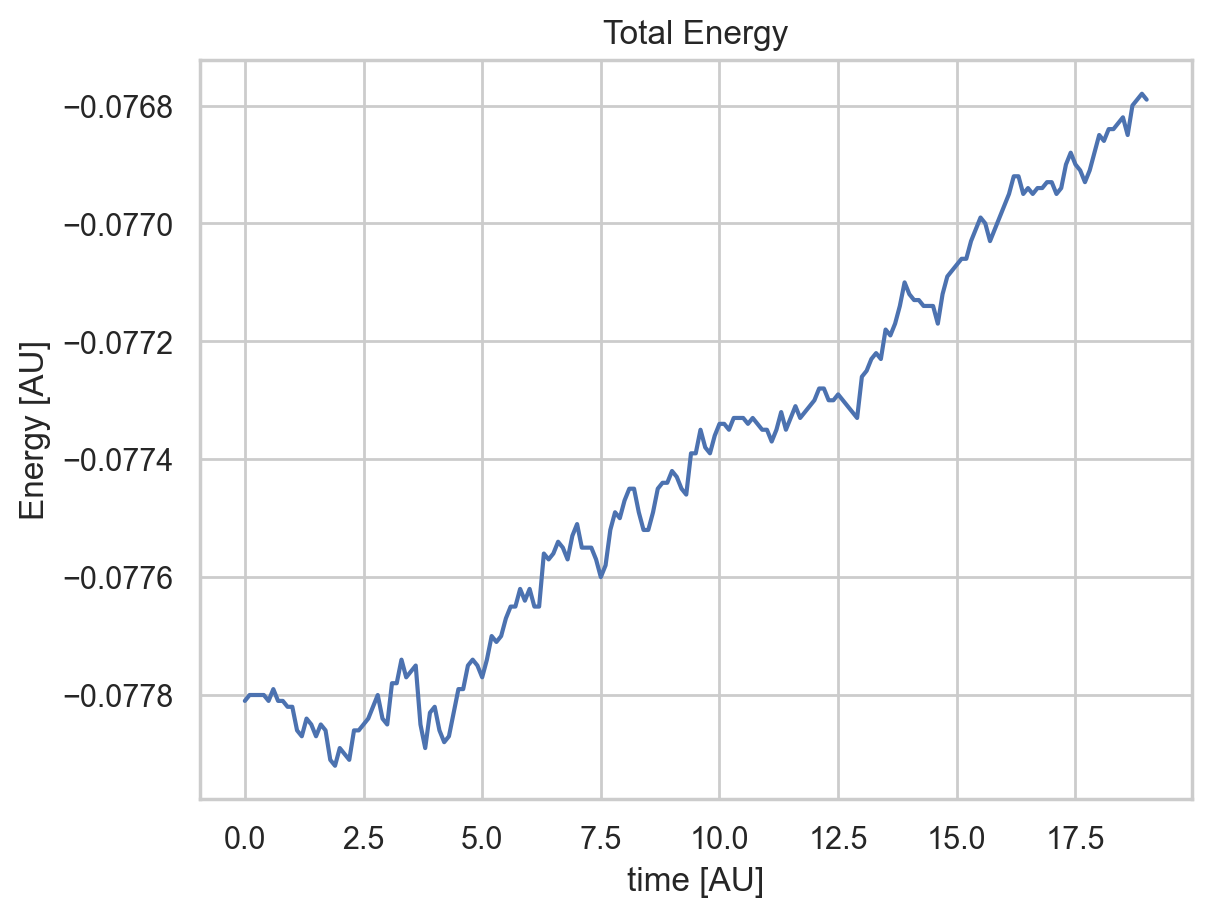

In [40]:
plt.plot(time_energy, T, label='T')
plt.plot(time_energy, U, label='U')
plt.plot(time_energy, E_tot, label=r'$E_{tot}$')

plt.xlabel('time [AU]')
plt.ylabel('Energy [AU]')
plt.title('Total Energy')
plt.legend()
plt.show()
############################################

plt.plot(time_energy, E_tot)
plt.xlabel('time [AU]')
plt.ylabel('Energy [AU]')
plt.title('Total Energy')
plt.show()

In [41]:
# relative error on total energy
Rel_err_perc = abs(E_stdev/mean_E)*100
print(f'Relative error: {Rel_err_perc:.2f} %')

Relative error: 0.43 %
